## DIFFERENTIAL PRIVACY - PRIVACY PRESERVING TECHNIQUE ANALYSIS IN PNEUMONIA DATASET

In [1]:
!pip install numpy pandas matplotlib tensorflow scikit-learn seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import os
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [3]:
train_dir = '/Users/ayushsharma/Downloads/chest_xray/train'
test_dir = '/Users/ayushsharma/Downloads/chest_xray/test'
val_dir = '/Users/ayushsharma/Downloads/chest_xray/val'

img_width, img_height = 224, 224
batch_size = 32

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for validation and test
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Baseline - CNN Model

In [4]:
def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

baseline_model = create_baseline_model()
baseline_history = baseline_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluating baseline model
baseline_results = baseline_model.evaluate(test_generator)
print(f"Baseline Test Loss: {baseline_results[0]:.4f}")
print(f"Baseline Test Accuracy: {baseline_results[1]:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 519ms/step - accuracy: 0.7510 - loss: 0.5856 - val_accuracy: 0.8125 - val_loss: 0.6020
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.8647 - loss: 0.3237 - val_accuracy: 0.7500 - val_loss: 0.9024
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - accuracy: 0.8924 - loss: 0.2568 - val_accuracy: 0.8125 - val_loss: 0.4283
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 947ms/step - accuracy: 0.9058 - loss: 0.2240 - val_accuracy: 0.7500 - val_loss: 0.6968
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 521ms/step - accuracy: 0.9228 - loss: 0.1941 - val_accuracy: 0.8125 - val_loss: 0.4738
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.6762 - loss: 0.6319
Baseline Test Loss: 0.3841
Baseline Test Accuracy: 0.8189


###  Defining Differential Privacy Noise Functions (Gaussian and Laplace)

In [5]:
def add_gaussian_noise(gradients, noise_multiplier, l2_norm_clip):
    
    # Clip gradients
    gradients_flat = tf.concat([tf.reshape(g, [-1]) for g in gradients], axis=0)
    l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients_flat)))
    scale = tf.maximum(l2_norm_clip / (l2_norm + 1e-10), 1.0)
    
    # Adding noise
    noisy_gradients = []
    for gradient in gradients:
        gradient = gradient * scale
        noise = tf.random.normal(shape=tf.shape(gradient), mean=0.0, stddev=l2_norm_clip * noise_multiplier)
        noisy_gradients.append(gradient + noise)
    
    return noisy_gradients

def add_laplace_noise(gradients, noise_multiplier, l1_norm_clip):
    
    # Clip gradients using L1 norm
    gradients_flat = tf.concat([tf.reshape(g, [-1]) for g in gradients], axis=0)
    l1_norm = tf.reduce_sum(tf.abs(gradients_flat))
    scale = tf.maximum(l1_norm_clip / (l1_norm + 1e-10), 1.0)
    
    # Adding noise
    noisy_gradients = []
    for gradient in gradients:
        gradient = gradient * scale
        # Use double exponential distribution (Laplace) by combining two exponential distributions
        noise = tf.random.stateless_gamma(
            shape=tf.shape(gradient), 
            seed=[42, 0], 
            alpha=1.0, 
            beta=1.0 / (l1_norm_clip * noise_multiplier)
        )
        noise = noise - tf.random.stateless_gamma(
            shape=tf.shape(gradient), 
            seed=[42, 1], 
            alpha=1.0, 
            beta=1.0 / (l1_norm_clip * noise_multiplier)
        )
        noisy_gradients.append(gradient + noise)
    
    return noisy_gradients

### Implementing DP-SGD with Gaussian Noise

In [6]:
class DPModelGaussian(Model):
    def __init__(self, model, l2_norm_clip, noise_multiplier):
        super(DPModelGaussian, self).__init__()
        self.model = model
        self.l2_norm_clip = l2_norm_clip
        self.noise_multiplier = noise_multiplier
    
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.model.losses)
        
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Apply DP-SGD
        noisy_gradients = add_gaussian_noise(gradients, self.noise_multiplier, self.l2_norm_clip)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(noisy_gradients, self.model.trainable_variables))
        
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}

# Creating a CNN model instance for DP-SGD
def create_dp_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Parameters for DP-SGD
l2_norm_clip = 1.0
noise_multiplier = 0.3  # Adjust for different privacy levels

# Create and compile DP model with Gaussian noise
base_model = create_dp_model()
dp_model_gaussian = DPModelGaussian(base_model, l2_norm_clip, noise_multiplier)
dp_model_gaussian.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training with DP-SGD
dp_history_gaussian = dp_model_gaussian.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluating DP model
dp_results_gaussian = dp_model_gaussian.evaluate(test_generator)
print(f"DP-SGD Gaussian Test Loss: {dp_results_gaussian[0]:.4f}")
print(f"DP-SGD Gaussian Test Accuracy: {dp_results_gaussian[1]:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:664: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:639: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


163/163 ━━━━━━━━━━━━━━━━━━━━ 710s 535ms/step - accuracy: 0.7324 - loss: 0.7159 - val_accuracy: 0.5000 - val_loss: 0.8017
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1470s 9s/step - accuracy: 0.7399 - loss: 0.7272 - val_accuracy: 0.5000 - val_loss: 0.8020
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.7630 - loss: 0.7410 - val_accuracy: 0.6250 - val_loss: 0.6024
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.7791 - loss: 0.7247 - val_accuracy: 0.6250 - val_loss: 0.6838
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 579ms/step - accuracy: 0.7946 - loss: 0.7367 - val_accuracy: 0.7500 - val_loss: 0.5921
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.7415 - loss: 0.5292
DP-SGD Gaussian Test Loss: 0.4174
DP-SGD Gaussian Test Accuracy: 0.8317


### Implementing DP-SGD with Laplace Noise

In [7]:
class DPModelLaplace(Model):
    def __init__(self, model, l1_norm_clip, noise_multiplier):
        super(DPModelLaplace, self).__init__()
        self.model = model
        self.l1_norm_clip = l1_norm_clip
        self.noise_multiplier = noise_multiplier
    
    def call(self, inputs, training=None):
        return self.model(inputs, training=training)
    
    def train_step(self, data):
        # Unpack the data
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.model.losses)
        
        # Calculate gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Apply DP-SGD with Laplace noise
        noisy_gradients = add_laplace_noise(gradients, self.noise_multiplier, self.l1_norm_clip)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(noisy_gradients, self.model.trainable_variables))
        
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}

# Parameters for DP-SGD with Laplace
l1_norm_clip = 1.5
noise_multiplier_laplace = 0.4  # Adjust for different privacy levels

# Create and compile DP model with Laplace noise
base_model_laplace = create_dp_model()
dp_model_laplace = DPModelLaplace(base_model_laplace, l1_norm_clip, noise_multiplier_laplace)
dp_model_laplace.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with DP-SGD (Laplace)
dp_history_laplace = dp_model_laplace.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate DP model
dp_results_laplace = dp_model_laplace.evaluate(test_generator)
print(f"DP-SGD Laplace Test Loss: {dp_results_laplace[0]:.4f}")
print(f"DP-SGD Laplace Test Accuracy: {dp_results_laplace[1]:.4f}")

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 654ms/step - accuracy: 0.6937 - loss: 0.6660 - val_accuracy: 0.5000 - val_loss: 2.2383
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6845 - loss: 0.7411 - val_accuracy: 0.6875 - val_loss: 1.0439
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.6762 - loss: 0.7228 - val_accuracy: 0.5625 - val_loss: 17.8557
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.6344 - loss: 0.7036 - val_accuracy: 0.5000 - val_loss: 16.8327
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 658ms/step - accuracy: 0.6342 - loss: 0.7075 - val_accuracy: 0.4375 - val_loss: 1.2639
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.3220 - loss: 5.7738
DP-SGD Laplace Test Loss: 9.5159
DP-SGD Laplace Test Accuracy: 0.6202


### Privacy-Utility Trade-off Analysis (Epsilon vs. Accuracy)


Training with Noise Multiplier: 0.1
Calculated Epsilon: 8.4853
Training Gaussian DP-SGD Model...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.7364 - loss: 0.7189 - val_accuracy: 0.5000 - val_loss: 0.7928
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 551ms/step - accuracy: 0.7427 - loss: 0.7365 - val_accuracy: 0.6250 - val_loss: 0.5956
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 581ms/step - accuracy: 0.7914 - loss: 0.7300 - val_accuracy: 0.6250 - val_loss: 0.6450
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 598ms/step - accuracy: 0.7947 - loss: 0.7219 - val_accuracy: 0.6875 - val_loss: 0.5496
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.8187 - loss: 0.7331 - val_accuracy: 0.7500 - val_loss: 0.5507
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.8151 - loss: 0.4281
Gaussian DP-SGD Accuracy: 0.8349
Training Laplace DP-SGD Model...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 678ms/step - accuracy: 0.7205 - loss: 0.7086 - val_accuracy: 0.5625 

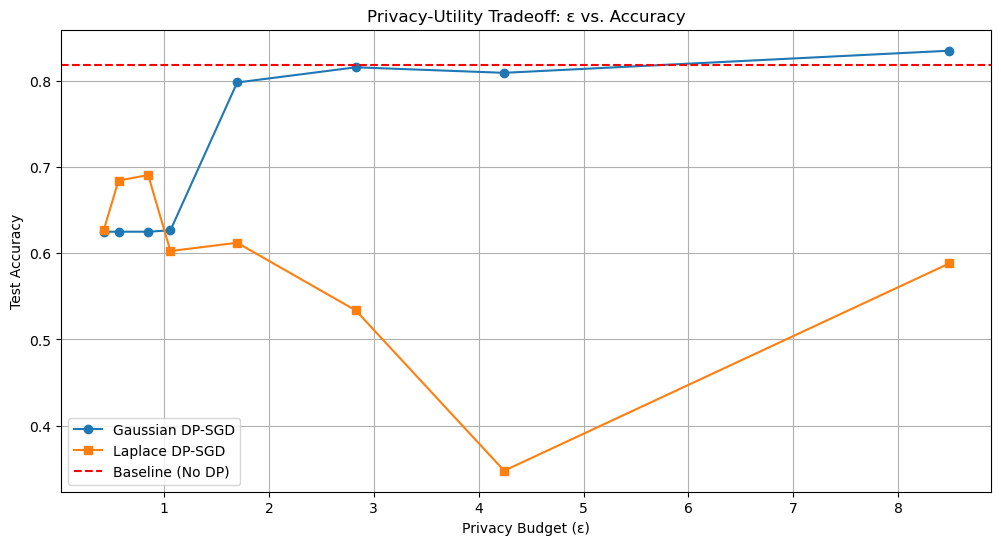

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate epsilon based on noise multiplier
def calculate_epsilon(noise_multiplier, epochs, n, batch_size, delta=1e-5):
    """
    Calculate epsilon for given privacy parameters
    - noise_multiplier: Amount of noise added
    - epochs: Number of training epochs
    - n: Total number of training examples
    - batch_size: Batch size used in training
    - delta: Target delta
    """
    steps = epochs * (n // batch_size)
    q = batch_size / n
    return (np.sqrt(2 * np.log(1.25/delta))) * (q * np.sqrt(steps)) / noise_multiplier

# Generate various noise levels
noise_multipliers = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0]
epsilons = []
gaussian_accuracies = []
laplace_accuracies = []
n_samples = train_generator.samples

# Run training for different noise levels
for noise in noise_multipliers:
    print(f"\nTraining with Noise Multiplier: {noise}")

    # Calculate epsilon
    epsilon = calculate_epsilon(noise, 5, n_samples, batch_size)
    epsilons.append(epsilon)
    print(f"Calculated Epsilon: {epsilon:.4f}")

    # Create and train Gaussian noise model
    print("Training Gaussian DP-SGD Model...")
    base_model = create_dp_model()
    dp_model = DPModelGaussian(base_model, l2_norm_clip, noise)
    dp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history_gaussian = dp_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1  # Show detailed output in Jupyter Notebook
    )
    results = dp_model.evaluate(test_generator, verbose=1)
    gaussian_accuracies.append(results[1])
    print(f"Gaussian DP-SGD Accuracy: {results[1]:.4f}")

    # Create and train Laplace noise model
    print("Training Laplace DP-SGD Model...")
    base_model_lap = create_dp_model()
    dp_model_lap = DPModelLaplace(base_model_lap, l1_norm_clip, noise)
    dp_model_lap.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history_laplace = dp_model_lap.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1  # Show detailed output in Jupyter Notebook
    )
    results_lap = dp_model_lap.evaluate(test_generator, verbose=1)
    laplace_accuracies.append(results_lap[1])
    print(f"Laplace DP-SGD Accuracy: {results_lap[1]:.4f}")

# Plot privacy-utility tradeoff
plt.figure(figsize=(12, 6))
plt.plot(epsilons, gaussian_accuracies, 'o-', label='Gaussian DP-SGD')
plt.plot(epsilons, laplace_accuracies, 's-', label='Laplace DP-SGD')
plt.axhline(y=baseline_results[1], color='r', linestyle='--', label='Baseline (No DP)')
plt.xlabel('Privacy Budget (ε)')
plt.ylabel('Test Accuracy')
plt.title('Privacy-Utility Tradeoff: ε vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()  # Ensure the plot is displayed in Jupyter Notebook


### Model Performance Comparison

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step


<Figure size 1200x800 with 0 Axes>

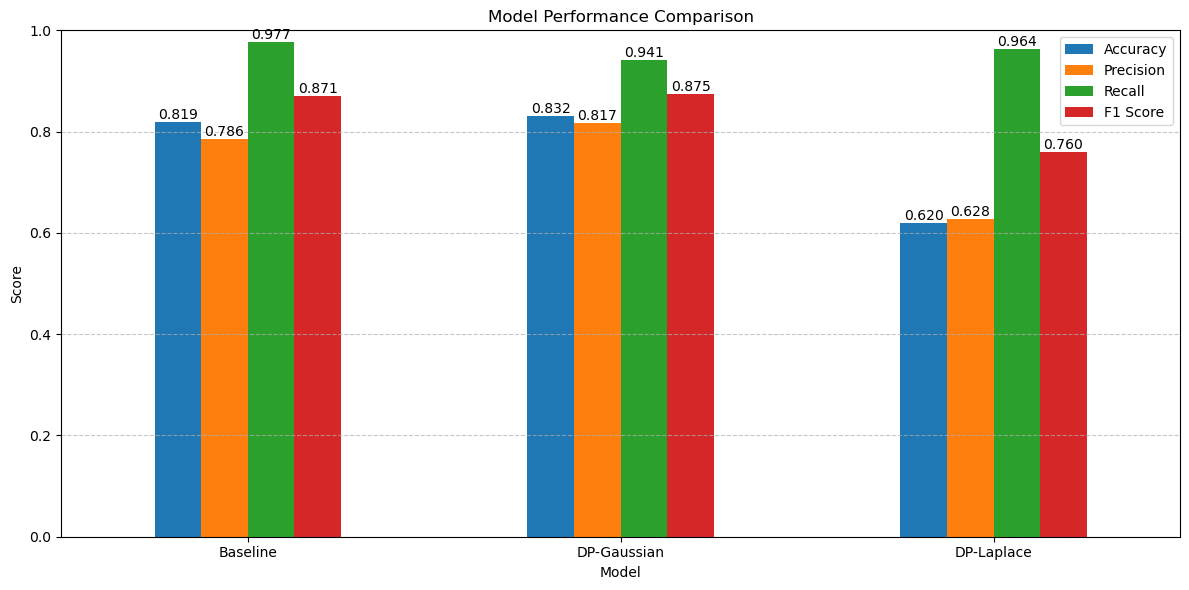

             Accuracy  Precision    Recall  F1 Score
Baseline     0.818910   0.785567  0.976923  0.870857
DP-Gaussian  0.831731   0.817372  0.941026  0.874851
DP-Laplace   0.620192   0.627713  0.964103  0.760364


In [9]:
# Collect predictions for all models
y_true = test_generator.classes
y_pred_baseline = (baseline_model.predict(test_generator) > 0.5).astype(int).flatten()
y_pred_gaussian = (dp_model_gaussian.predict(test_generator) > 0.5).astype(int).flatten()
y_pred_laplace = (dp_model_laplace.predict(test_generator) > 0.5).astype(int).flatten()

# Calculate metrics
models = ['Baseline', 'DP-Gaussian', 'DP-Laplace']
predictions = [y_pred_baseline, y_pred_gaussian, y_pred_laplace]
metrics_data = []

for model, pred in zip(models, predictions):
    acc = accuracy_score(y_true, pred)
    prec = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    metrics_data.append([acc, prec, rec, f1])

# Create dataframe for metrics
metrics_df = pd.DataFrame(metrics_data, 
                         index=models, 
                         columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Plot metrics comparison
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', ylim=(0, 1), figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f')
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print metrics table
print(metrics_df)

### Learning Curves

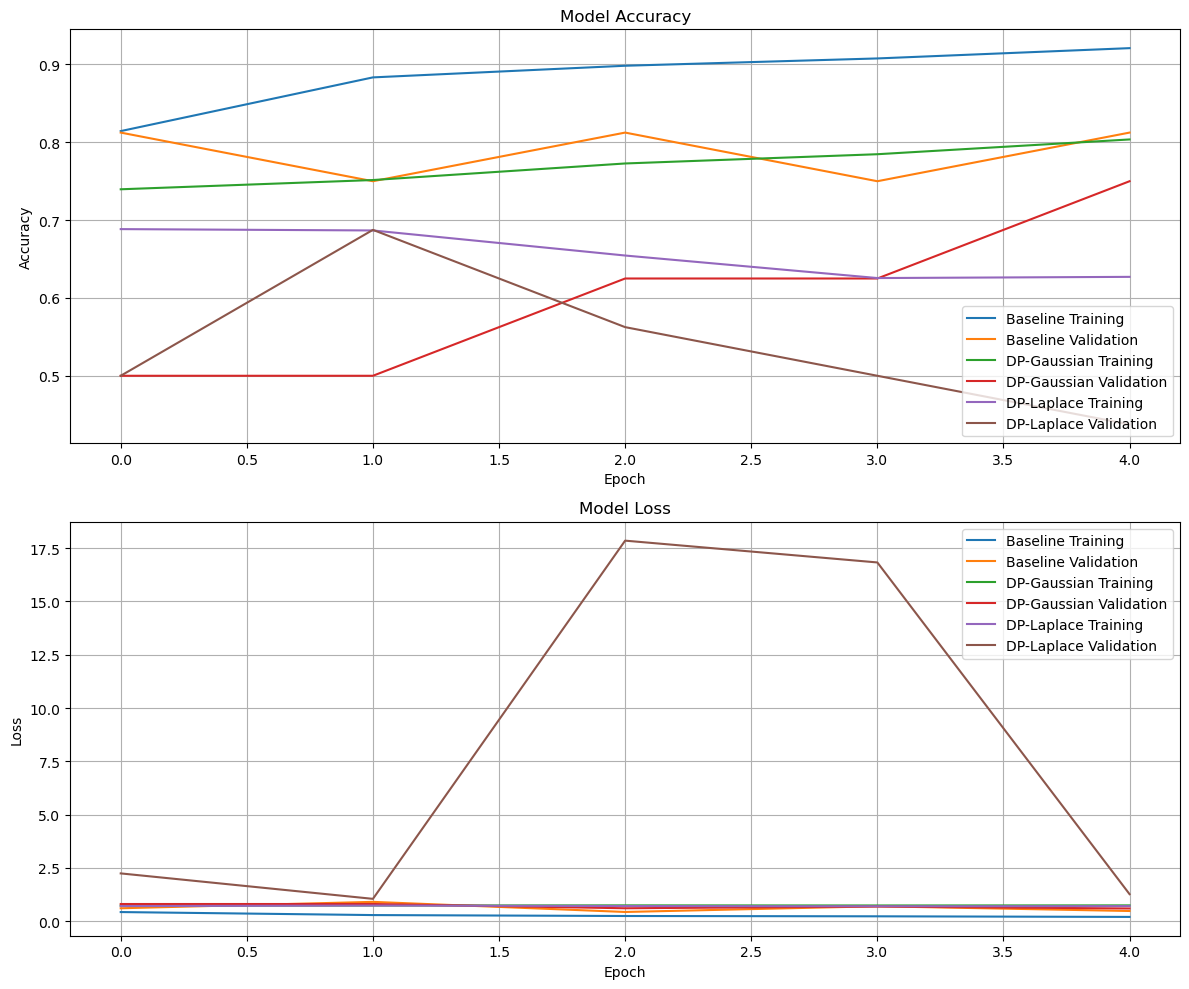

In [10]:
# Plot training history for all models
plt.figure(figsize=(12, 10))

# Accuracy subplot
plt.subplot(2, 1, 1)
plt.plot(baseline_history.history['accuracy'], label='Baseline Training')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation')
plt.plot(dp_history_gaussian.history['accuracy'], label='DP-Gaussian Training')
plt.plot(dp_history_gaussian.history['val_accuracy'], label='DP-Gaussian Validation')
plt.plot(dp_history_laplace.history['accuracy'], label='DP-Laplace Training')
plt.plot(dp_history_laplace.history['val_accuracy'], label='DP-Laplace Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(2, 1, 2)
plt.plot(baseline_history.history['loss'], label='Baseline Training')
plt.plot(baseline_history.history['val_loss'], label='Baseline Validation')
plt.plot(dp_history_gaussian.history['loss'], label='DP-Gaussian Training')
plt.plot(dp_history_gaussian.history['val_loss'], label='DP-Gaussian Validation')
plt.plot(dp_history_laplace.history['loss'], label='DP-Laplace Training')
plt.plot(dp_history_laplace.history['val_loss'], label='DP-Laplace Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrix Visualization

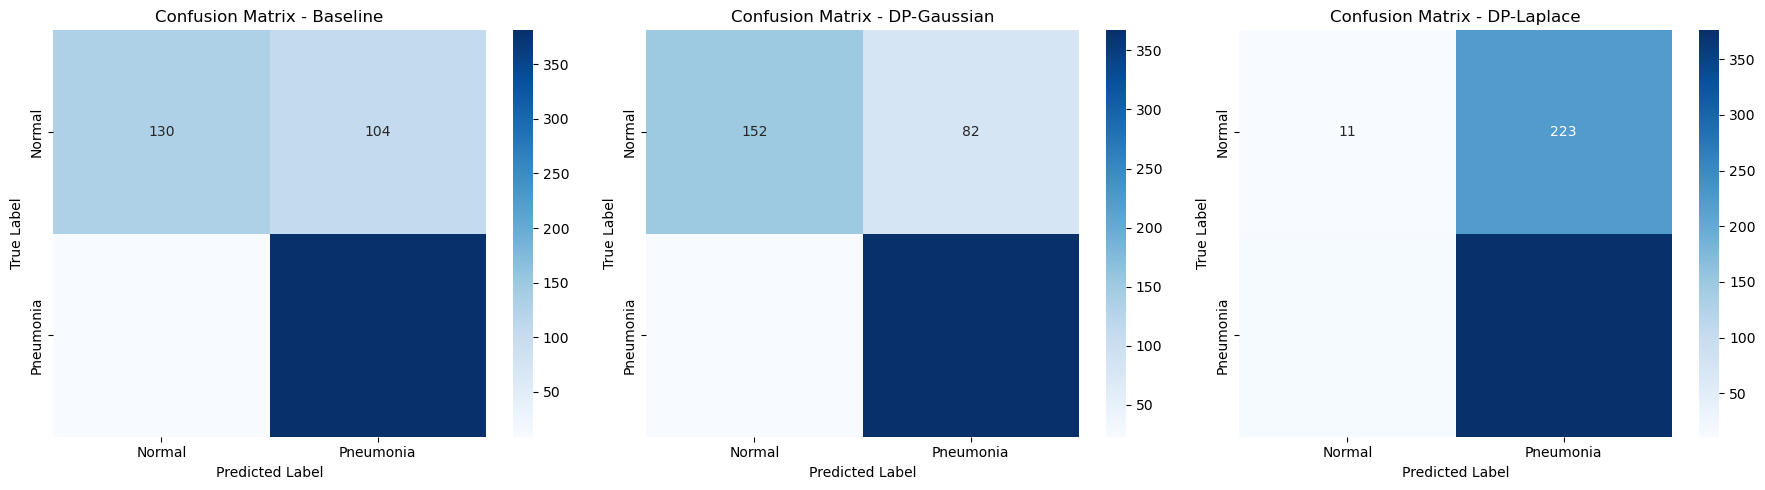

In [11]:
# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (pred, model_name) in enumerate(zip(predictions, models)):
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['Normal', 'Pneumonia'])
    axes[i].set_yticklabels(['Normal', 'Pneumonia'])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### Effect of Batch Size on Privacy

Found 5216 images belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:664: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Found 5216 images belonging to 2 classes.


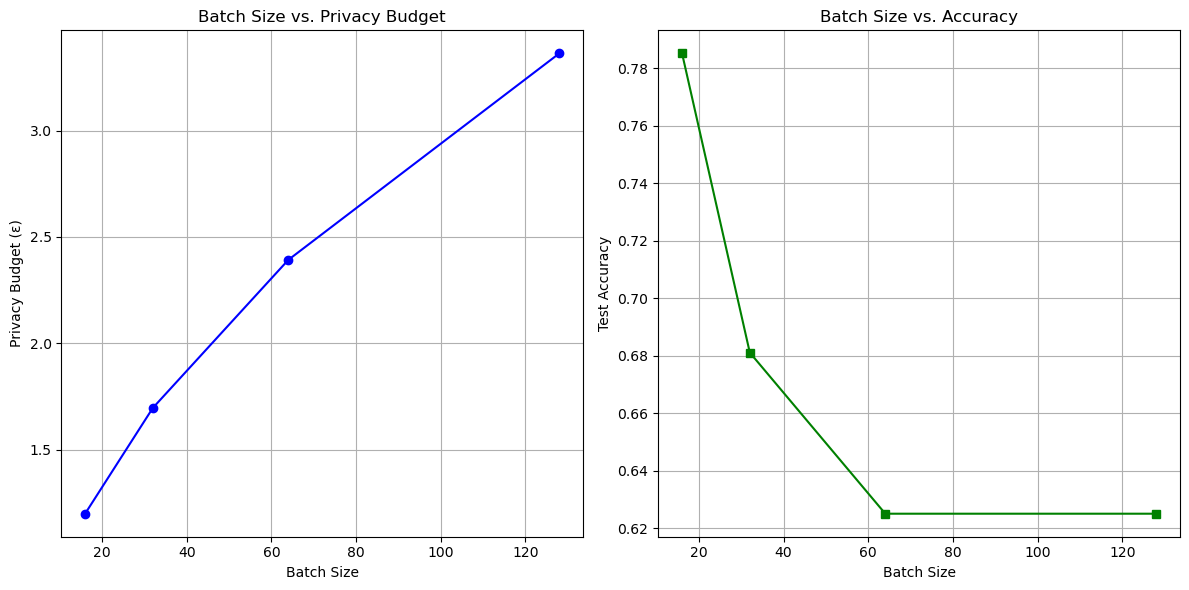

In [12]:
# Test different batch sizes and their effect on privacy and accuracy
batch_sizes = [16, 32, 64, 128]
noise_multiplier = 0.5  # Fixed noise level
batch_epsilons = []
batch_accuracies = []

for bs in batch_sizes:
    # Calculate epsilon
    epsilon = calculate_epsilon(noise_multiplier, 5, n_samples, bs)
    batch_epsilons.append(epsilon)
    
    # Create generator with new batch size
    temp_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=bs,
        class_mode='binary'
    )
    
    # Create and train model
    base_model = create_dp_model()
    dp_model = DPModelGaussian(base_model, l2_norm_clip, noise_multiplier)
    dp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dp_model.fit(
        temp_generator,
        steps_per_epoch=temp_generator.samples // bs,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=0
    )
    results = dp_model.evaluate(test_generator, verbose=0)
    batch_accuracies.append(results[1])

# Plot batch size effects
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, batch_epsilons, 'o-', color='blue')
plt.xlabel('Batch Size')
plt.ylabel('Privacy Budget (ε)')
plt.title('Batch Size vs. Privacy Budget')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, batch_accuracies, 's-', color='green')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Batch Size vs. Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig('batch_size_effects.png', dpi=300, bbox_inches='tight')
plt.show()

### Impact of Clipping Threshold

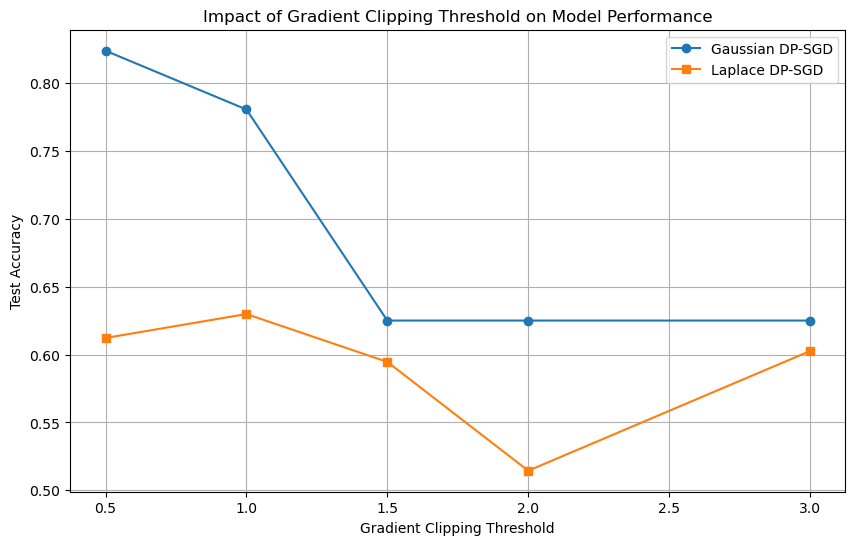

In [13]:
# Test different clipping thresholds and their effect on model performance
clip_thresholds = [0.5, 1.0, 1.5, 2.0, 3.0]
clip_accuracies_gaussian = []
clip_accuracies_laplace = []
noise_multiplier = 0.5  # Fixed noise level

for clip in clip_thresholds:
    # Gaussian
    base_model = create_dp_model()
    dp_model = DPModelGaussian(base_model, clip, noise_multiplier)
    dp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dp_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=0
    )
    results = dp_model.evaluate(test_generator, verbose=0)
    clip_accuracies_gaussian.append(results[1])
    
    # Laplace
    base_model_lap = create_dp_model()
    dp_model_lap = DPModelLaplace(base_model_lap, clip, noise_multiplier)
    dp_model_lap.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dp_model_lap.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=0
    )
    results_lap = dp_model_lap.evaluate(test_generator, verbose=0)
    clip_accuracies_laplace.append(results_lap[1])

# Plot clipping threshold effects
plt.figure(figsize=(10, 6))
plt.plot(clip_thresholds, clip_accuracies_gaussian, 'o-', label='Gaussian DP-SGD')
plt.plot(clip_thresholds, clip_accuracies_laplace, 's-', label='Laplace DP-SGD')
plt.xlabel('Gradient Clipping Threshold')
plt.ylabel('Test Accuracy')
plt.title('Impact of Gradient Clipping Threshold on Model Performance')
plt.legend()
plt.grid(True)
plt.savefig('clipping_threshold_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create a more comprehensive privacy budget vs accuracy plot
noise_levels = np.linspace(0.1, 2.0, 10)
epsilons_detailed = []
gaussian_accs = []

for noise in noise_levels:
    epsilon = calculate_epsilon(noise, 5, n_samples, batch_size)
    epsilons_detailed.append(epsilon)
    
    base_model = create_dp_model()
    dp_model = DPModelGaussian(base_model, l2_norm_clip, noise)
    dp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    dp_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=0
    )
    results = dp_model.evaluate(test_generator, verbose=0)
    gaussian_accs.append(results[1])

# Plot detailed privacy budget curve
plt.figure(figsize=(12, 6))
baseline_acc = baseline_results[1]
plt.plot(epsilons_detailed, gaussian_accs, 'o-', color='blue', label='DP-SGD')
plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline ({baseline_acc:.3f})')

# Highlight optimal privacy-utility tradeoff point
optimal_idx = np.argmin(np.abs(np.array(gaussian_accs) - (baseline_acc * 0.95)))
plt.scatter([epsilons_detailed[optimal_idx]], [gaussian_accs[optimal_idx]], 
           color='green', s=100, zorder=5, label=f'Recommended (ε={epsilons_detailed[optimal_idx]:.2f})')

# Add annotations
plt.annotate('High Privacy\nLower Utility', xy=(epsilons_detailed[1], gaussian_accs[1]),
            xytext=(epsilons_detailed[1], gaussian_accs[1]-0.15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
            ha='center', fontsize=10)

plt.annotate('Low Privacy\nHigher Utility', xy=(epsilons_detailed[-2], gaussian_accs[-2]),
            xytext=(epsilons_detailed[-2], gaussian_accs[-2]-0.15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
            ha='center', fontsize=10)

plt.xlabel('Privacy Budget (ε)')
plt.ylabel('Test Accuracy')
plt.title('Privacy Budget Distribution and Recommended Operating Point')
plt.legend()
plt.grid(True)
plt.savefig('privacy_budget_recommendation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Function to extract features from penultimate layer
def extract_features(model, data_generator):
    # Create a model that outputs the features of the penultimate layer
    feature_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=model.get_layer('dense1').output
    )
    
    # Extract features
    features = []
    labels = []
    
    # Get a batch of images
    batch_count = 0
    max_batches = 10  # Limit to 10 batches for visualization
    
    for x_batch, y_batch in data_generator:
        if batch_count >= max_batches:
            break
        batch_features = feature_model.predict(x_batch)
        features.append(batch_features)
        labels.append(y_batch)
        batch_count += 1
    
    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

# Extract features from both models
baseline_features, baseline_labels = extract_features(baseline_model_named, test_generator)
dp_features, dp_labels = extract_features(dp_model_gaussian_named, test_generator)

# Use t-SNE to reduce dimensionality for visualization
from sklearn.manifold import TSNE

# Reduce dimensionality of features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
baseline_tsne = tsne.fit_transform(baseline_features)
dp_tsne = tsne.fit_transform(dp_features)

# Visualize t-SNE embeddings
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
normal_mask = baseline_labels == 0
pneumonia_mask = baseline_labels == 1

plt.scatter(baseline_tsne[normal_mask, 0], baseline_tsne[normal_mask, 1], 
           alpha=0.7, c='blue', label='Normal')
plt.scatter(baseline_tsne[pneumonia_mask, 0], baseline_tsne[pneumonia_mask, 1], 
           alpha=0.7, c='red', label='Pneumonia')
plt.title('Baseline Model Feature Space')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(dp_tsne[normal_mask, 0], dp_tsne[normal_mask, 1], 
           alpha=0.7, c='blue', label='Normal')
plt.scatter(dp_tsne[pneumonia_mask, 0], dp_tsne[pneumonia_mask, 1], 
           alpha=0.7, c='red', label='Pneumonia')
plt.title('DP Model Feature Space')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_space_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Function to apply random noise to test images
def add_test_noise(images, noise_level):
    noisy_images = images.copy()
    noise = np.random.normal(0, noise_level, images.shape)
    noisy_images = noisy_images + noise
    noisy_images = np.clip(noisy_images, 0, 1)  # Ensure values stay in valid range
    return noisy_images

# Get a batch of test images
x_test_batch, y_test_batch = next(test_generator)

# Test model robustness against different noise levels
noise_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3]
baseline_robustness = []
dp_gaussian_robustness = []
dp_laplace_robustness = []

plt.figure(figsize=(16, 8))
for i, noise_level in enumerate(noise_levels):
    # Apply noise to test images
    noisy_images = add_test_noise(x_test_batch, noise_level)
    
    # Get predictions
    baseline_preds = baseline_model.predict(noisy_images)
    dp_gaussian_preds = dp_model_gaussian.predict(noisy_images)
    dp_laplace_preds = dp_model_laplace.predict(noisy_images)
    
    # Calculate accuracy
    baseline_acc = accuracy_score(y_test_batch, (baseline_preds > 0.5).astype(int).flatten())
    dp_gaussian_acc = accuracy_score(y_test_batch, (dp_gaussian_preds > 0.5).astype(int).flatten())
    dp_laplace_acc = accuracy_score(y_test_batch, (dp_laplace_preds > 0.5).astype(int).flatten())
    
    baseline_robustness.append(baseline_acc)
    dp_gaussian_robustness.append(dp_gaussian_acc)
    dp_laplace_robustness.append(dp_laplace_acc)
    
    # Display example noisy images for visualization
    if i < 6:
        plt.subplot(2, 3, i+1)
        plt.imshow(noisy_images[0])
        plt.title(f'Noise Level: {noise_level}')
        plt.axis('off')

plt.tight_layout()
plt.savefig('noise_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot robustness results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, baseline_robustness, 'o-', label='Baseline Model')
plt.plot(noise_levels, dp_gaussian_robustness, 's-', label='DP-Gaussian Model')
plt.plot(noise_levels, dp_laplace_robustness, '^-', label='DP-Laplace Model')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Model Robustness to Input Noise')
plt.legend()
plt.grid(True)
plt.savefig('model_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create a comprehensive privacy-utility report
plt.figure(figsize=(14, 10))

# Define regions of interest for privacy
high_privacy = 1.0  # ε ≤ 1.0 considered high privacy
medium_privacy = 5.0  # 1.0 < ε ≤ 5.0 considered medium privacy
# ε > 5.0 considered low privacy

# Sort the privacy data for better visualization
sorted_indices = np.argsort(epsilons_detailed)
sorted_epsilons = np.array(epsilons_detailed)[sorted_indices]
sorted_accuracies = np.array(gaussian_accs)[sorted_indices]

# Plot the main privacy-utility trade-off curve
plt.subplot(2, 1, 1)
plt.plot(sorted_epsilons, sorted_accuracies, 'o-', color='blue', label='DP-SGD Accuracy')
plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline ({baseline_acc:.3f})')

# Add privacy regions
plt.axvspan(0, high_privacy, alpha=0.2, color='green', label='High Privacy Region')
plt.axvspan(high_privacy, medium_privacy, alpha=0.2, color='yellow', label='Medium Privacy Region')
plt.axvspan(medium_privacy, max(sorted_epsilons)+1, alpha=0.2, color='red', label='Low Privacy Region')

# Highlight optimal points in each region
high_privacy_indices = np.where(sorted_epsilons <= high_privacy)[0]
if len(high_privacy_indices) > 0:
    best_high_privacy_idx = high_privacy_indices[np.argmax(sorted_accuracies[high_privacy_indices])]
    plt.scatter([sorted_epsilons[best_high_privacy_idx]], [sorted_accuracies[best_high_privacy_idx]], 
               color='darkgreen', s=100, zorder=5, 
               label=f'Best High Privacy (ε={sorted_epsilons[best_high_privacy_idx]:.2f}, acc={sorted_accuracies[best_high_privacy_idx]:.3f})')

medium_privacy_indices = np.where((sorted_epsilons > high_privacy) & (sorted_epsilons <= medium_privacy))[0]
if len(medium_privacy_indices) > 0:
    best_medium_privacy_idx = medium_privacy_indices[np.argmax(sorted_accuracies[medium_privacy_indices])]
    plt.scatter([sorted_epsilons[best_medium_privacy_idx]], [sorted_accuracies[best_medium_privacy_idx]], 
               color='orange', s=100, zorder=5, 
               label=f'Best Medium Privacy (ε={sorted_epsilons[best_medium_privacy_idx]:.2f}, acc={sorted_accuracies[best_medium_privacy_idx]:.3f})')

# Add annotations
utility_loss_threshold = 0.05  # 5% accuracy drop
acceptable_privacy_idx = np.where(sorted_accuracies >= (baseline_acc - utility_loss_threshold))[0]
if len(acceptable_privacy_idx) > 0:
    recommended_idx = acceptable_privacy_idx[0]  # Select the one with highest privacy
    plt.scatter([sorted_epsilons[recommended_idx]], [sorted_accuracies[recommended_idx]], 
               color='purple', s=120, zorder=5, marker='*',
               label=f'Recommended (ε={sorted_epsilons[recommended_idx]:.2f}, acc={sorted_accuracies[recommended_idx]:.3f})')

plt.xlabel('Privacy Budget (ε)')
plt.ylabel('Test Accuracy')
plt.title('Privacy-Utility Trade-off Analysis')
plt.legend(loc='lower right')
plt.grid(True)

# Add a secondary plot showing accuracy loss vs privacy gain
plt.subplot(2, 1, 2)
accuracy_loss = baseline_acc - sorted_accuracies
privacy_gain = 1 / sorted_epsilons  # Inverse of epsilon as a measure of privacy gain

plt.plot(privacy_gain, accuracy_loss, 'o-', color='purple')
plt.xlabel('Privacy Gain (1/ε)')
plt.ylabel('Accuracy Loss')
plt.title('Cost of Privacy: Accuracy Loss vs. Privacy Gain')
plt.grid(True)

# Add annotations for key points
plt.axhline(y=utility_loss_threshold, color='red', linestyle='--', 
           label=f'Acceptable Utility Loss Threshold ({utility_loss_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.savefig('privacy_utility_detailed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print recommendations
print("Privacy Budget Recommendations:")
print("-" * 50)
print(f"Baseline model accuracy: {baseline_acc:.4f}")
print()

# High privacy recommendation
if len(high_privacy_indices) > 0:
    high_privacy_eps = sorted_epsilons[best_high_privacy_idx]
    high_privacy_acc = sorted_accuracies[best_high_privacy_idx]
    high_privacy_loss = baseline_acc - high_privacy_acc
    print(f"High Privacy Option (ε ≤ 1.0):")
    print(f"  Epsilon: {high_privacy_eps:.2f}")
    print(f"  Accuracy: {high_privacy_acc:.4f}")
    print(f"  Accuracy Loss: {high_privacy_loss:.4f} ({high_privacy_loss/baseline_acc*100:.1f}%)")
    print(f"  Corresponding Noise Multiplier: {1.0/high_privacy_eps:.2f}")
    print()

# Medium privacy recommendation
if len(medium_privacy_indices) > 0:
    medium_privacy_eps = sorted_epsilons[best_medium_privacy_idx]
    medium_privacy_acc = sorted_accuracies[best_medium_privacy_idx]
    medium_privacy_loss = baseline_acc - medium_privacy_acc
    print(f"Medium Privacy Option (1.0 < ε ≤ 5.0):")
    print(f"  Epsilon: {medium_privacy_eps:.2f}")
    print(f"  Accuracy: {medium_privacy_acc:.4f}")
    print(f"  Accuracy Loss: {medium_privacy_loss:.4f} ({medium_privacy_loss/baseline_acc*100:.1f}%)")
    print(f"  Corresponding Noise Multiplier: {1.0/medium_privacy_eps:.2f}")
    print()

# Overall recommendation
if len(acceptable_privacy_idx) > 0:
    rec_eps = sorted_epsilons[recommended_idx]
    rec_acc = sorted_accuracies[recommended_idx]
    rec_loss = baseline_acc - rec_acc
    print(f"RECOMMENDED SETTING:")
    print(f"  Epsilon: {rec_eps:.2f}")
    print(f"  Accuracy: {rec_acc:.4f}")
    print(f"  Accuracy Loss: {rec_loss:.4f} ({rec_loss/baseline_acc*100:.1f}%)")
    print(f"  Corresponding Noise Multiplier: {1.0/rec_eps:.2f}")
    print(f"  This setting provides the best balance between privacy and utility")